In [1]:
!pip install rouge_score
!pip uninstall pyarrow -y
!pip uninstall datasets -y
!pip install pyarrow==10.0.1 datasets==2.4.0
!pip install py7zr
!pip install transformers nltk
!pip install datasets transformers
!pip install wandb
!pip install accelerate -U
!pip install transformers[torch]

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=ae51fc87b44368a9e2c3a88a7688113da880cea1d71b3c4d2e58d57d973ad514
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Found existing installation: pyarrow 14.0.2
Uninstalling pyarrow-14.0.2:
  Successfully uninstalled pyarrow-14.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could tak

In [2]:
!git clone https://github.com/ryanzhumich/AESLC

Cloning into 'AESLC'...
remote: Enumerating objects: 17469, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 17469 (delta 1), reused 0 (delta 0), pack-reused 17461
Receiving objects: 100% (17469/17469), 7.36 MiB | 13.53 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [3]:
import os
import pandas as pd

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and word.isalnum()]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [6]:
def sanitize_subject(subject):
    # Remove special characters from the subject
    return re.sub(r'[^a-zA-Z0-9\s]', '', subject)

In [7]:
import os
import re

def load_emails_and_subjects(emails_directory):
    emails = []
    subjects = []

    for filename in os.listdir(emails_directory):
        file_path = os.path.join(emails_directory, filename)

        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            email_text = file.read()

            # Extract subject from email body using regex
            match = re.search(r'@subject\s+(.*)', email_text, re.IGNORECASE | re.DOTALL)

            if match:
                subject = match.group(1).strip()
                email_body = re.sub(r'@subject\n(.+)\n', '', email_text).strip()
                preprocessed_email = preprocess_text(email_body)

                emails.append(preprocessed_email)
                subjects.append(subject)

    return emails, subjects

In [8]:
train_emails, tain_subjects = load_emails_and_subjects('/content/AESLC/enron_subject_line/train')
dev_emails, dev_subjects = load_emails_and_subjects('/content/AESLC/enron_subject_line/dev')
test_emails, test_subjects = load_emails_and_subjects('/content/AESLC/enron_subject_line/test')

In [9]:
train_data = pd.DataFrame({'subject_line': tain_subjects, 'email_body': train_emails})
dev_data = pd.DataFrame({'subject_line': dev_subjects, 'email_body': dev_emails})
test_data = pd.DataFrame({'subject_line': test_subjects, 'email_body': test_emails})

In [10]:
train_data.head()

,subject_line,email_body
0,Travel plans,scheduled nyc danbury connecticut tomorrow aft...
1,guest id,kathy please issue guest user id bob lawrence ...
2,EEOS / NEPCO Weekly Project Update... W/E O...,please find attached eeos nepco weekly project...
3,Update,morning enron credit rating downgraded junk st...
4,NOTICE OF OPEN SEASON,columbia gas transmission corporation notice i...


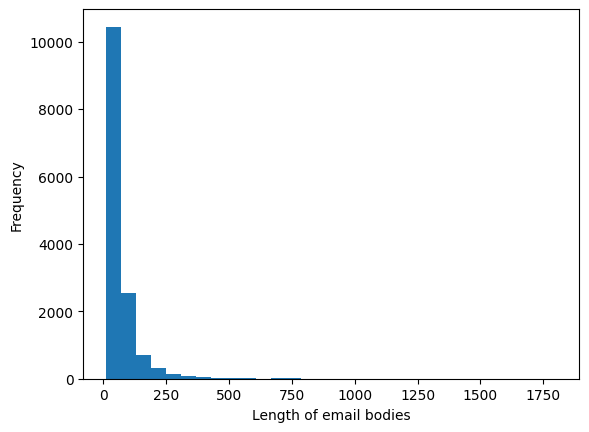

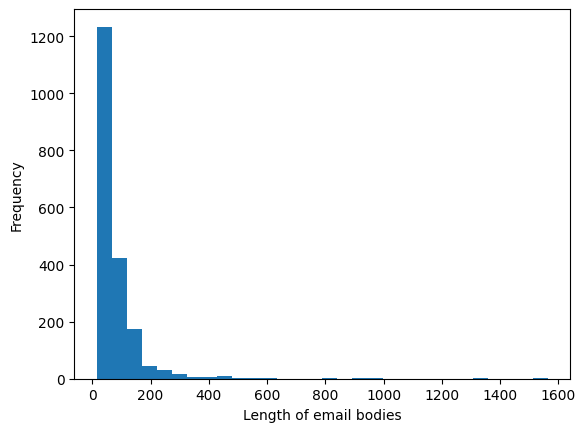

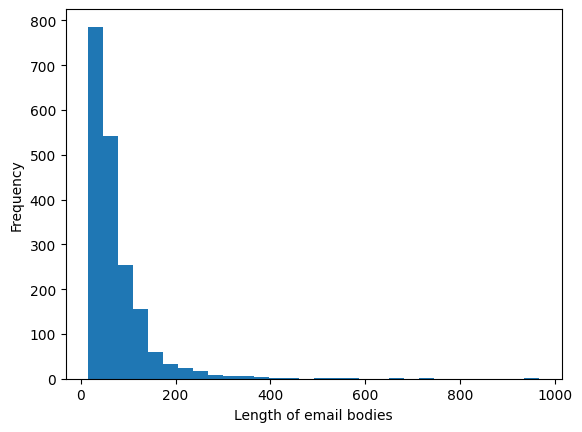

In [11]:
import matplotlib.pyplot as plt

def plot_data(data):
    lengths = [len(text.split()) for text in data['email_body']]
    plt.hist(lengths, bins=30)
    plt.xlabel('Length of email bodies')
    plt.ylabel('Frequency')
    plt.show()

plot_data(train_data)
plot_data(dev_data)
plot_data(test_data)

In [12]:
from datasets import Dataset, DatasetDict

In [13]:
train_dataset = Dataset.from_pandas(train_data)
dev_dataset = Dataset.from_pandas(dev_data)
test_dataset = Dataset.from_pandas(test_data)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'dev': dev_dataset,
    'test': test_dataset
})

In [14]:
print("\n", dev_data["email_body"].iloc[1])


 kevin wanted mention thing sure already time really need done every deal link physical tagg deal putting sitara number link field put tagg number comment section sitara deal also booked tagg put tagg number sci sitara deal also booked tagg put eol number sitara tagg every eol deal also tagg system origin field select enron line every eol deal manually rebook every eol deal fails trouble let know follow thanks ann0 instruction deal ann1 reminder every deal ann2 thing needing done deal


In [15]:
print("\n", dev_data["subject_line"].iloc[1])


 Procedures

@ann0
instructions for each deal

@ann1
a few reminders for every deal

@ann2
things needing to be done on each deal


In [16]:
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [17]:
#tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

In [18]:
#model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

In [19]:
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset

In [20]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [21]:
import torch

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Laye

In [23]:
def get_feature(batch):
  encodings = tokenizer(batch['email_body'], text_target =batch['subject_line'], max_length=1024, truncation=True)

  encodings = {'input_ids' : encodings['input_ids'],
               'attention_mask' : encodings['attention_mask'],
               'labels' : encodings['labels']}

  return encodings

In [25]:
dataset_features = dataset_dict.map(get_feature, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [26]:
columns = ['input_ids', 'labels', 'attention_mask']
dataset_features.set_format(type='torch', columns=columns)

In [27]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [28]:
split_data_set = dataset_features['train'].train_test_split(test_size=0.2)

In [29]:
dataset_dict['train'] = split_data_set['train']
dataset_dict['eval'] = split_data_set['test']

In [30]:
train_data.head()

,subject_line,email_body
0,Travel plans,scheduled nyc danbury connecticut tomorrow aft...
1,guest id,kathy please issue guest user id bob lawrence ...
2,EEOS / NEPCO Weekly Project Update... W/E O...,please find attached eeos nepco weekly project...
3,Update,morning enron credit rating downgraded junk st...
4,NOTICE OF OPEN SEASON,columbia gas transmission corporation notice i...


In [31]:
train_dataset

Dataset({
    features: ['subject_line', 'email_body'],
    num_rows: 14436
})

In [32]:
def preprocess_data(data_set_val):
    inputs = ["generate subject line: " + email for email in data_set_val['email_body']]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(data_set_val['subject_line'], max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [33]:
train_dataset = train_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?ba/s]

In [34]:
# Define training arguments
# training_args = TrainingArguments(
#     output_dir='./results',
#     evaluation_strategy='epoch',
#     learning_rate=2e-5,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     report_to='none'
# )

training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir='./logs',
    logging_steps=500,
    evaluation_strategy="epoch",
    report_to='none'
)

# Define Trainer
model_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
model_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.092200,2.692427
2,0.064300,2.489501
3,0.043700,2.605197


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=10827, training_loss=0.10275504493730996, metrics={'train_runtime': 4330.5986, 'train_samples_per_second': 10.0, 'train_steps_per_second': 2.5, 'total_flos': 1.320323326672896e+16, 'train_loss': 0.10275504493730996, 'epoch': 3.0})

In [35]:
evaluation_results = model_trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")

Evaluation results: {'eval_loss': 2.6051971912384033, 'eval_runtime': 48.132, 'eval_samples_per_second': 39.599, 'eval_steps_per_second': 9.91, 'epoch': 3.0}


In [36]:
sample_email = """
All: Attached you will find a list that reflects your seat assignments for Business Continuity Planning (BCP).
These seats are located on the 30th and 31st Floors of Enron Center North (ECN).
As previously communicated, you will report to these designated seats in the event of an outage in ECS.
The exception to this is as follows: If your seat assignment is located on the 31st Floor, you will report to your original location that you occupied prior to your move into ECS.
This will hold true until the Monday after Thanksgiving, as we will have the 31st floor seats set up at that time.
Testing: Once you have moved to ECS, if you would like to test your BCP location, you will be able to test your seat for functionality every Thursday from 3-6pm.
Testing is not required, but is highly recommended.
If anyone has any questions or concerns about these procedures, please feel free to contact me at any time.
Regards,

@subject
BCP Seat Assignments

@ann0
your seat assignments for business continuity planning (bcp).

@ann1
bcp seat assignments

@ann2
here are your seat assignments for the business continuity planning event
"""
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: BCP Seat Assignments


In [37]:
sample_email = "Hi team, the project deadline has been extended to next Friday. Please ensure all deliverables are completed by then. Thanks."
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: Hi Team!


In [38]:
sample_email = "Michelle;  This is the presentation which was provided to the HR VP's.The HR VPs were tasked with going off to met their BU OTCs and devise plans around the three components.We are currently collating those plans into one document.We'll send that along to you when completed.Pls call if you have any questions."
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: Pls call if you have any


In [39]:
sample_email = "To confirm:  Mark Thomas Mike Presley  both previously on the list for Netco's Market Risk/Research Group have resigned.I'm combing the Estate for replacements.DP"
inputs = tokenizer(sample_email, return_tensors="pt").input_ids.to(device)
outputs = model.generate(inputs, max_length=10, num_beams=2, repetition_penalty=2.5, length_penalty=1.0, early_stopping=True)
print("Generated Subject Line:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated Subject Line: DPI


In [40]:
# Save the model locally
model_save_path = "./email_subuject_bart_base"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


Model and tokenizer saved to ./email_subuject_bart_base


In [41]:
# Generate subject lines for the test set
def generate_subject_line(email_body):
    inputs = tokenizer("generate subject line: " + email_body, return_tensors="pt", max_length=512, truncation=True)
    # Move inputs to the GPU if available
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    # Access input_ids from the dictionary
    outputs = model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

test_data['generated_subject_line'] = test_data['email_body'].apply(generate_subject_line)

In [42]:
test_data.head()

,subject_line,email_body,generated_subject_line
0,Rotation Roll-off Dates for Associate Candidat...,tom included information received potential ca...,Potential Candidate Dates
1,Announcement!!! We have moved!\n\n@ann0\nnew s...,newsletter moved effort provide subscriber bes...,Ann2 Newsletter moved to new address
2,Potential solution\n\n@ann0\nwould a reverse s...,lay sir almost positive avenue pursued get enr...,A.Word.A.Day--Suggestions on Enron's Ann2 Poss...
3,Corp Dev Weekly Report\n\n@ann0\nhsr filing in...,trailblazer gathering information hsr filing h...,ANN1/Hsr filing information and ann2 bankruptc...
4,How to get emails....\n\n@ann0\nemail writing\...,know write email get email would hardly call l...,Ann2 - last two email


In [43]:
!zip -r email_subuject_bart_base.zip -r   email_subuject_bart_base

  adding: email_subuject_bart_base/ (stored 0%)
  adding: email_subuject_bart_base/special_tokens_map.json (deflated 85%)
  adding: email_subuject_bart_base/merges.txt (deflated 53%)
  adding: email_subuject_bart_base/tokenizer_config.json (deflated 76%)
  adding: email_subuject_bart_base/model.safetensors (deflated 8%)
  adding: email_subuject_bart_base/vocab.json (deflated 68%)
  adding: email_subuject_bart_base/generation_config.json (deflated 47%)
  adding: email_subuject_bart_base/config.json (deflated 64%)


In [44]:
from rouge_score import rouge_scorer

test_data.to_csv()

emailbd = test_data['email_body'].tolist()
preds = test_data['generated_subject_line'].tolist()
temp = test_data[['subject_line']]
labels = temp.values.tolist()
#print(len(labels))
#print(len(preds))
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Generate predictions and calculate ROUGE scores
all_rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

# Rouge expects input as list of strings for predictions and references
for i in range(len(labels)):
  for lbl in labels[i]:
    #rouge_output = rouge.compute(predictions=preds, references=lbl, use_stemmer=True)
    scores = scorer.score(preds[i], lbl)
    for key in all_rouge_scores.keys():
      all_rouge_scores[key].append(scores[key].fmeasure)


avg_rouge_scores = {key: sum(scores)/len(scores) for key, scores in all_rouge_scores.items()}
print("Average ROUGE Scores:", avg_rouge_scores)

Average ROUGE Scores: {'rouge1': 0.3737617017740769, 'rouge2': 0.2443837936724036, 'rougeL': 0.3664682399117245}


In [45]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
!cp email_subuject_bart_base.zip /content/drive/MyDrive